Brain Tumor MRI Segmentation

In [ ]:
### UPDATE PATH TO MOUNT AT GOOGLE DRIVE TO RUN ON GOOGLE COLAB ###
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/VIP Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data Pre-Processing

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import os

In [ ]:
### UPDATE ACCORDINGLY ###
img_dir = r'/dataset/data'
mask_dir = r'/dataset/groundtruth'
output_t_dir = r'/dataset/output_thresholding'
output_k_dir = r'/dataset/output_kmeans'

In [ ]:
# Load image with masks
image_paths = sorted(
    [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith(".tif")],
    key=lambda x: int(os.path.basename(x).split('.')[0])
)

mask_paths = sorted(
    [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith(".tif")],
    key=lambda x: int(os.path.basename(x).split('.')[0])
)


# Read all images and masks
images = [cv2.imread(img_path) for img_path in image_paths]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]
masks = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in mask_paths]

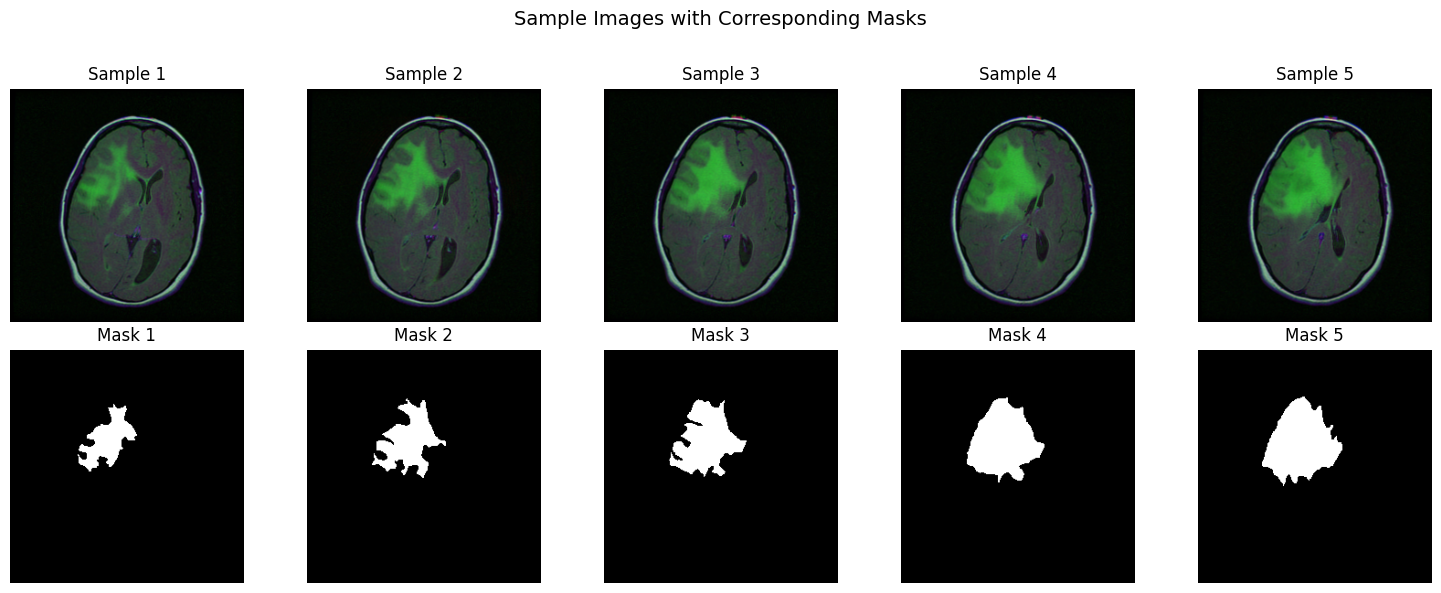

In [ ]:
# Select 5 sample images and their corresponding masks
sample_indices = [335, 336, 337, 338, 339]
sample_images = [images[i] for i in sample_indices]
sample_masks = [masks[i] for i in sample_indices]

# Create a figure with 2 rows (image and mask) and 5 columns (samples)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
fig.suptitle("Sample Images with Corresponding Masks", fontsize=14)

for i in range(5):
    # Original Image (First Row)
    axes[0, i].imshow(sample_images[i])
    axes[0, i].set_title(f"Sample {i+1}")
    axes[0, i].axis("off")

    # Corresponding Mask (Second Row)
    axes[1, i].imshow(sample_masks[i], cmap="gray")
    axes[1, i].set_title(f"Mask {i+1}")
    axes[1, i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

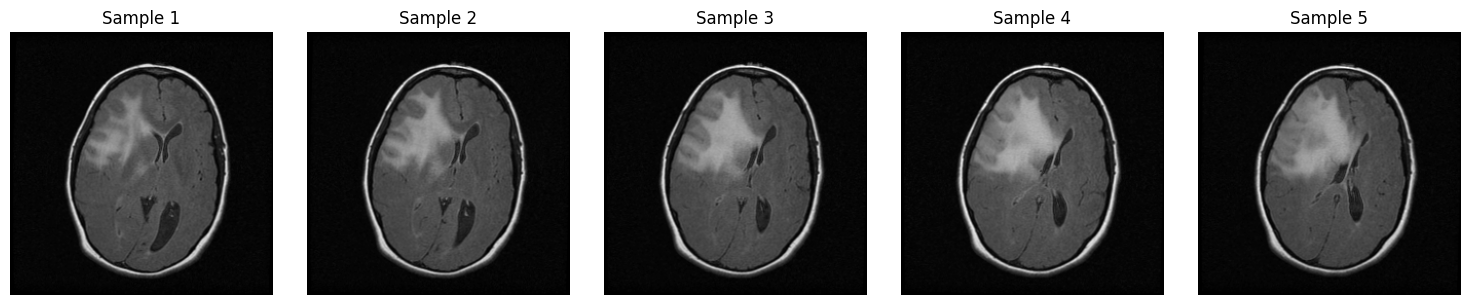

In [ ]:
# Convert all images to grayscale
grayscale_images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]

# Select 5 sample grayscale images for display
num_samples = min(5, len(grayscale_images))
sample_gray_images = [grayscale_images[i] for i in sample_indices]

# Display a sample of five greyscale input images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

# Display the sample grayscale images with axis labels
for i, ax in enumerate(axes):
    ax.imshow(sample_gray_images[i], cmap="gray")
    ax.set_title(f"Sample {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

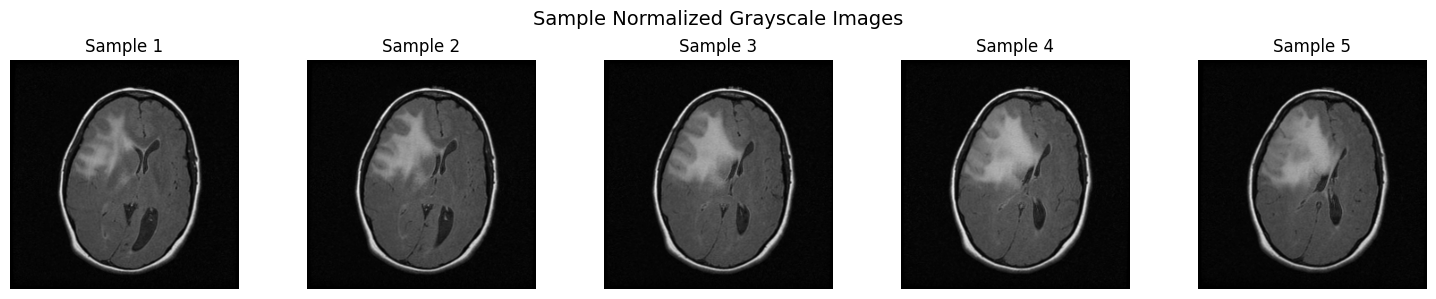

In [ ]:
# Normalize images to range [0, 1] for better contrast
normalized_images = [(img - np.min(img)) / (np.max(img) - np.min(img)) for img in grayscale_images]

num_samples = min(5, len(normalized_images))
sample_norm_images = [normalized_images[i] for i in sample_indices]

# Display the sample normalized images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
fig.suptitle("Sample Normalized Grayscale Images", fontsize=14)

for i in range(num_samples):
    axes[i].imshow(sample_norm_images[i], cmap="gray")
    axes[i].set_title(f"Sample {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

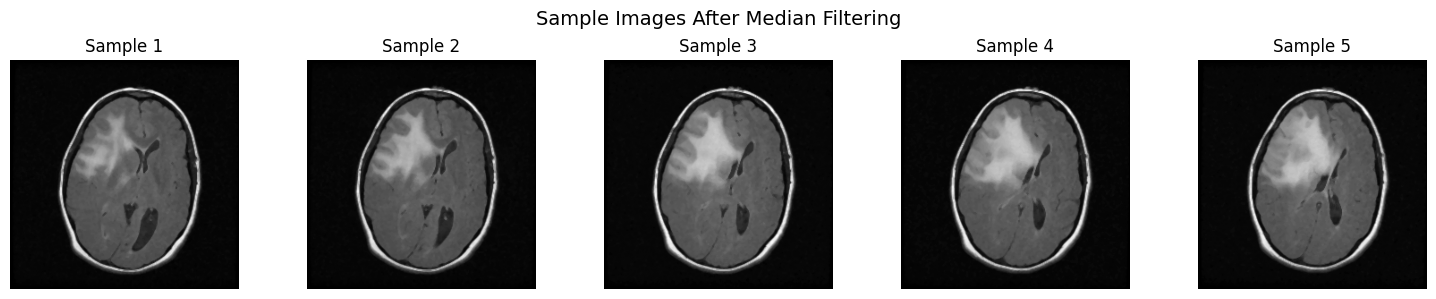

In [ ]:
# Convert normalized images to uint8
normalized_images = [(img * 255).astype(np.uint8) for img in normalized_images]

# Apply Median Filtering for denoising
median_images = [cv2.medianBlur(img, 3) for img in normalized_images]

# Select 5 sample images for display
num_samples = min(5, len(median_images))
sample_median = [median_images[i] for i in sample_indices]

# Display sample images after Median Filtering
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
fig.suptitle("Sample Images After Median Filtering", fontsize=14)

for i in range(num_samples):
    axes[i].imshow(sample_median[i], cmap="gray")
    axes[i].set_title(f"Sample {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
sobel_images = []

for i, img in enumerate(median_images):
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal edges
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)  # Vertical edges
    sobel_combined = cv2.magnitude(sobel_x, sobel_y)  # Combine both directions

    # Normalize and convert to uint8
    sobel_img = cv2.normalize(sobel_combined, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    sobel_images.append(sobel_img)

    # Free memory
    del sobel_x, sobel_y, sobel_combined, sobel_img

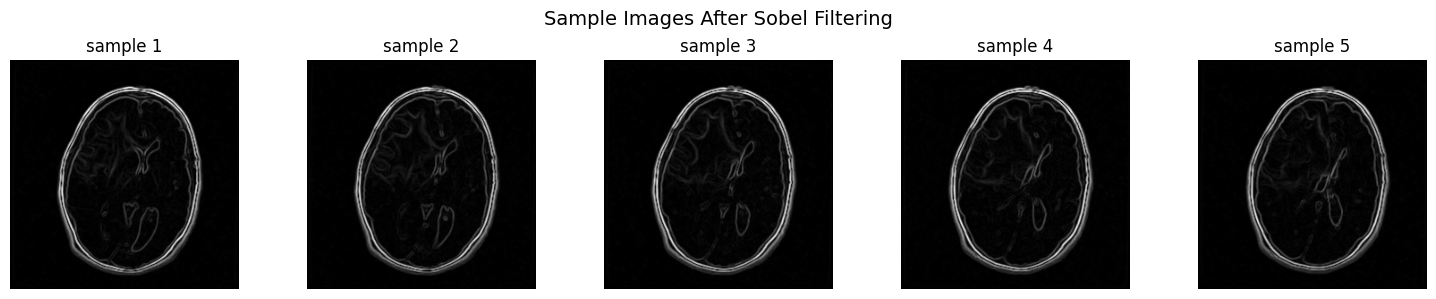

In [ ]:
# Median + Sobel filter
# Display the sample Sobel images
sample_sobel_images = [sobel_images[i] for i in sample_indices]
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Sample Images After Sobel Filtering", fontsize=14)

for i, ax in enumerate(axes):
    ax.imshow(sample_sobel_images[i], cmap="gray")
    ax.set_title(f"sample {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

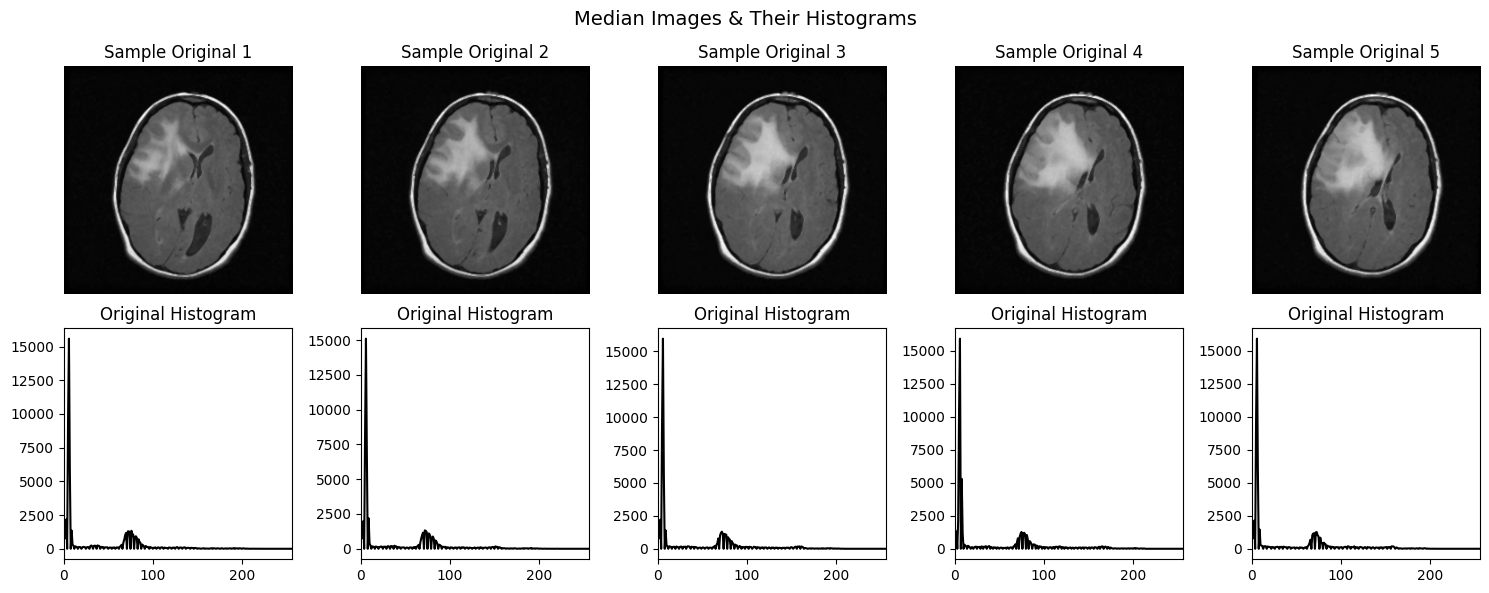

In [ ]:
# Median + Histogram Equalization
# Apply Histogram Equalization to all images
equalized_images = [cv2.equalizeHist(img) for img in median_images]

# display 5 samples
sample_original = [median_images[i] for i in sample_indices]
sample_equalized = [equalized_images[i] for i in sample_indices]

# Compute and plot histograms
def plot_histogram(image, ax, title):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    ax.plot(hist, color="black")
    ax.set_xlim([0, 256])
    ax.set_title(title)

# Display Sample Original Images and Histograms
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
fig.suptitle("Median Images & Their Histograms", fontsize=14)

for i in range(num_samples):
    # Original Image
    axes[0, i].imshow(sample_original[i], cmap="gray")
    axes[0, i].set_title(f"Sample Original {i+1}")
    axes[0, i].axis("off")

    # Original Histogram
    plot_histogram(sample_original[i], axes[1, i], "Original Histogram")

plt.tight_layout()
plt.show()

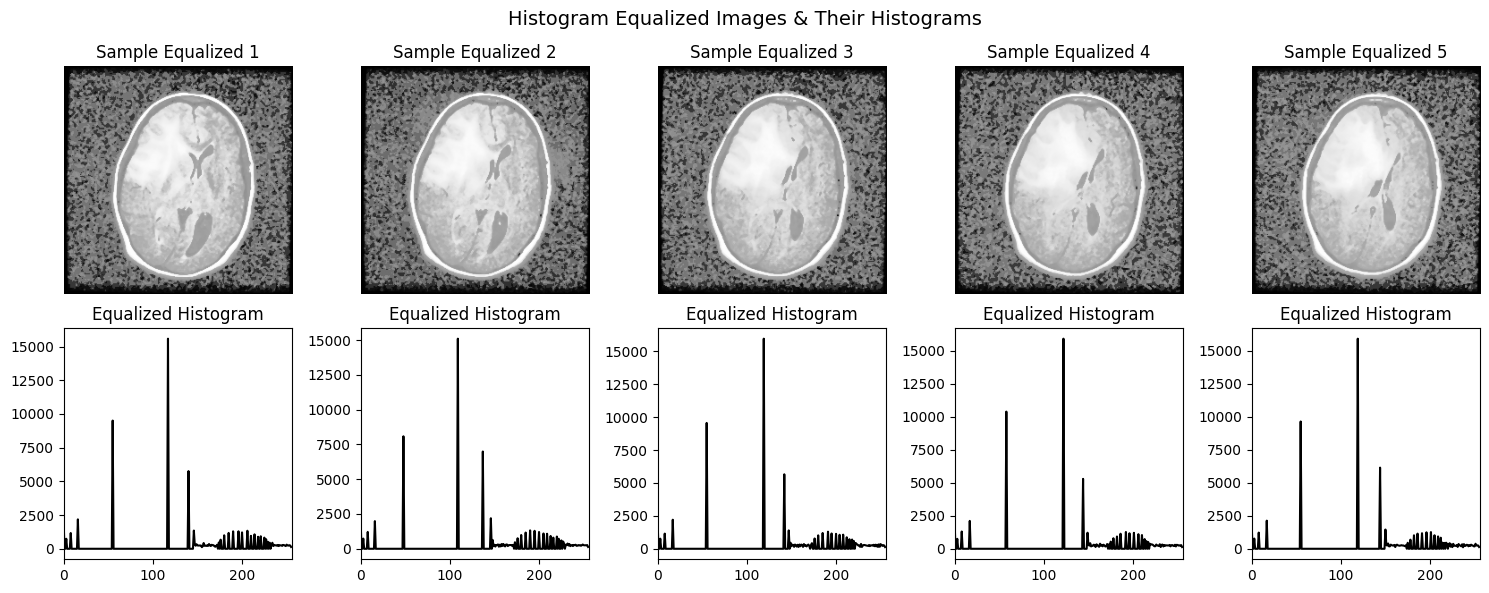

In [ ]:
# Display Sample Equalized Images and Histograms
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
fig.suptitle("Histogram Equalized Images & Their Histograms", fontsize=14)

for i in range(num_samples):
    # Equalized Image
    axes[0, i].imshow(sample_equalized[i], cmap="gray")
    axes[0, i].set_title(f"Sample Equalized {i+1}")
    axes[0, i].axis("off")

    # Equalized Histogram
    plot_histogram(sample_equalized[i], axes[1, i], "Equalized Histogram")

plt.tight_layout()
plt.show()

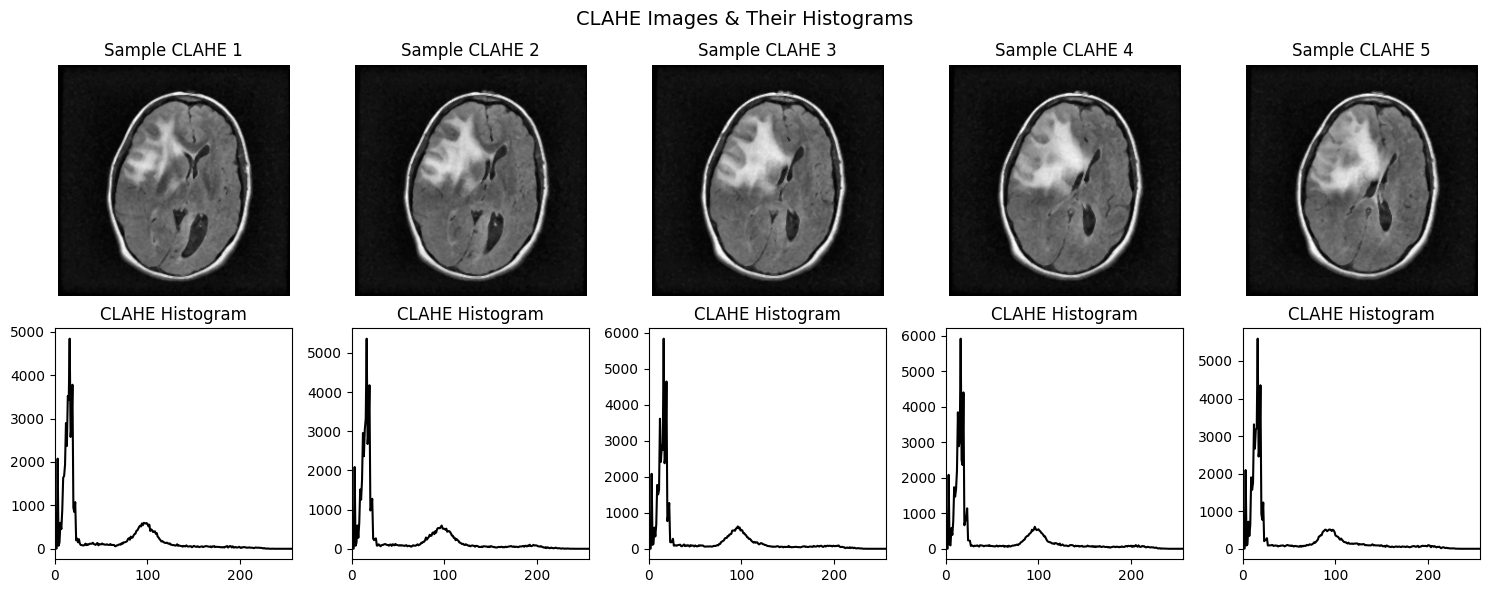

In [ ]:
# Median + CLAHE
# Apply CLAHE (Clip Limit = 2.0, Tile Grid Size = 8x8)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_images = [clahe.apply(img) for img in median_images]

# 5 sample images
sample_clahe = [clahe_images[i] for i in sample_indices]

# Display Sample CLAHE Images and Histograms
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
fig.suptitle("CLAHE Images & Their Histograms", fontsize=14)

for i in range(num_samples):
    # CLAHE Image
    axes[0, i].imshow(sample_clahe[i], cmap="gray")
    axes[0, i].set_title(f"Sample CLAHE {i+1}")
    axes[0, i].axis("off")

    # CLAHE Histogram
    plot_histogram(sample_clahe[i], axes[1, i], "CLAHE Histogram")

plt.tight_layout()
plt.show()

Input image options for segmentation:
- median_images (Original image with median filtering)
- sobel_images (Median filter + Sobel edge detection)
- equalized_images (Median filter + Histogram equalization)
- clahe_images (Median filter + CLAHE)

## 2. Segmentation using Thresholding & Morphological Operations


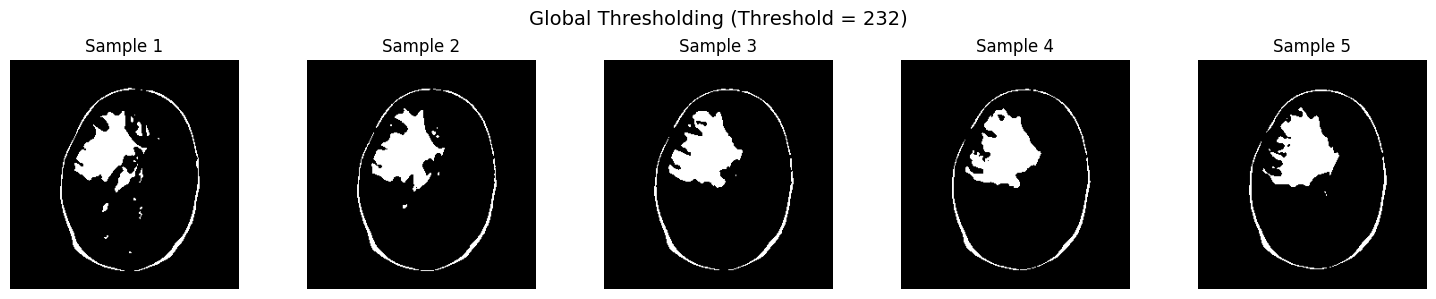

In [ ]:
threshold_value = 232

blurred_images = [cv2.GaussianBlur(img, (3, 3), 0) for img in equalized_images]

# Apply global thresholding
threshold_images = [cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY)[1] for img in blurred_images]

# Select 5 samples
sample_threshold = [threshold_images[i] for i in sample_indices]

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
fig.suptitle(f"Global Thresholding (Threshold = {threshold_value})", fontsize=14)

for i in range(num_samples):
    axes[i].imshow(sample_threshold[i], cmap='gray')
    axes[i].set_title(f"Sample {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

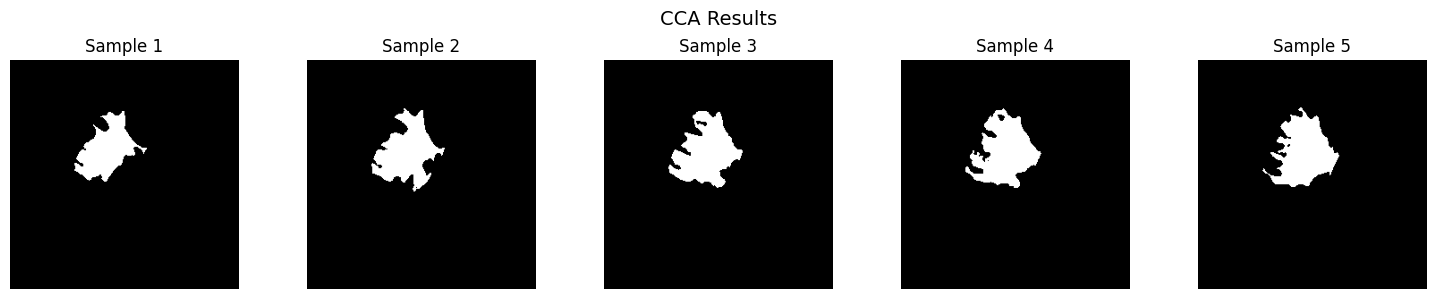

In [ ]:
# Apply CCA
def keep_largest_component(image):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(image, connectivity=8)

    if num_labels < 2:
        return image

    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

    filtered = np.zeros_like(image)
    filtered[labels == largest_label] = 255

    return filtered

CCA_images = [keep_largest_component(img) for img in threshold_images]


# Display results
sample_CCA = [CCA_images[i] for i in sample_indices]

fig, axes = plt.subplots(1, len(sample_CCA), figsize=(15, 3))
fig.suptitle("CCA Results", fontsize=14)

for i, img in enumerate(sample_CCA):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Sample {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

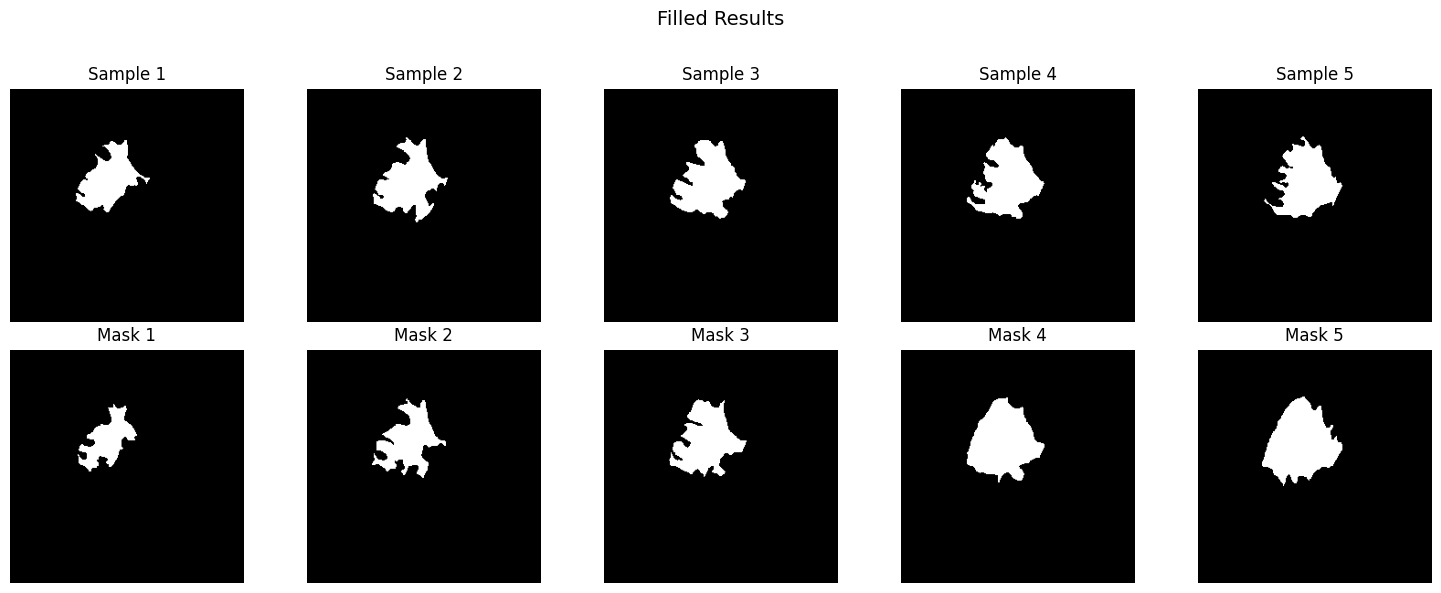

In [ ]:
# Apply Filling Contour
def fill_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled = np.zeros_like(image)
    cv2.drawContours(filled, contours, -1, 255, thickness=cv2.FILLED)
    return filled

filled_images = [fill_contours(img) for img in CCA_images]

sample_filled = [filled_images[i] for i in sample_indices]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
fig.suptitle("Filled Results", fontsize=14)

for i, img in enumerate(sample_filled):
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f"Sample {i+1}")
    axes[0, i].axis("off")

    axes[1, i].imshow(sample_masks[i], cmap="gray")
    axes[1, i].set_title(f"Mask {i+1}")
    axes[1, i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 3. Segmentation using K-Means Clustering & Morphological Filtering

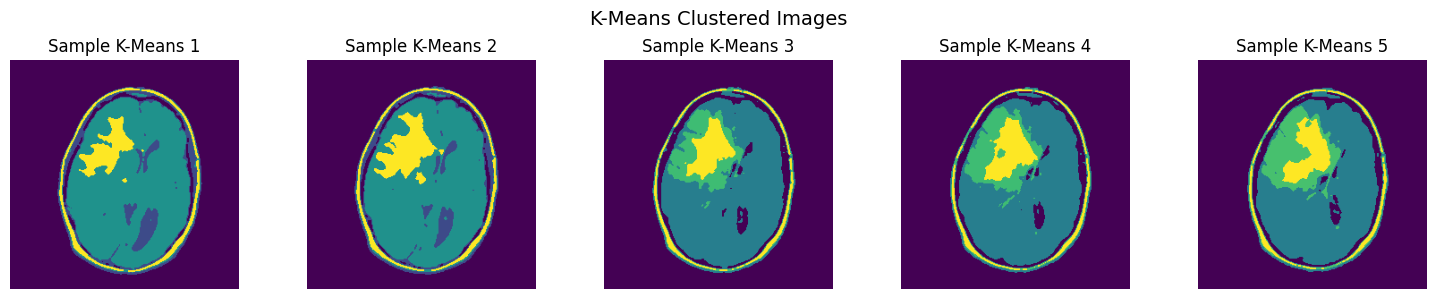

In [ ]:
from sklearn.cluster import KMeans

def apply_kmeans(image, k):
    # Reshape image into a 2D array of pixels
    pixel_values = image.reshape((-1, 1)).astype(np.float32)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(pixel_values)

    # Replace pixel values with their cluster centers
    clustered_image = kmeans.cluster_centers_[labels]
    clustered_image = clustered_image.reshape(image.shape)

    return clustered_image.astype(np.uint8)

# Apply K-Means to median images
kmeans_results = [apply_kmeans(img, 4) for img in median_images]

# Display Sample K-Means Images
sample_kmeans = [kmeans_results[i] for i in sample_indices]

num_samples = len(sample_indices)
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
fig.suptitle("K-Means Clustered Images", fontsize=14)

for i in range(num_samples):
    axes[i].imshow(sample_kmeans[i], cmap="viridis")
    axes[i].set_title(f"Sample K-Means {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

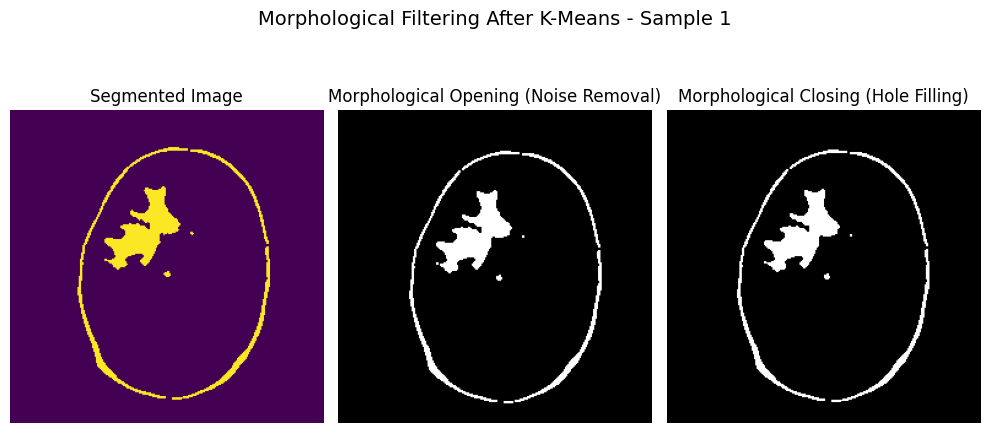

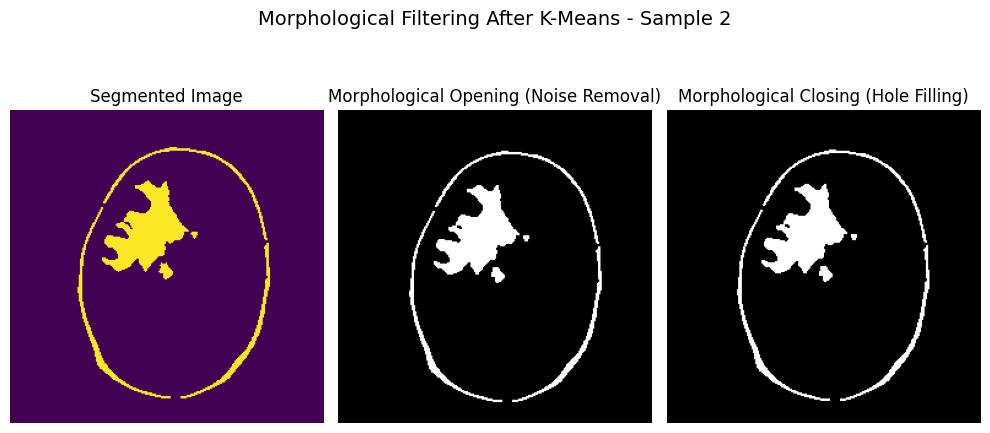

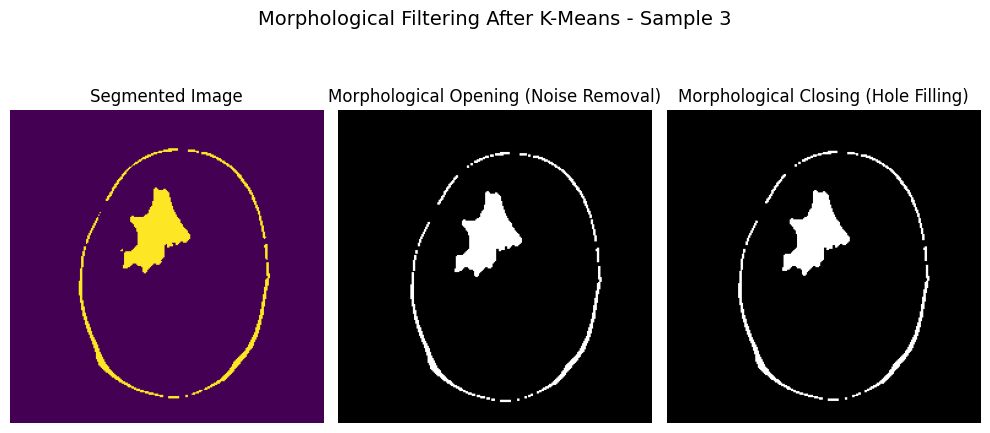

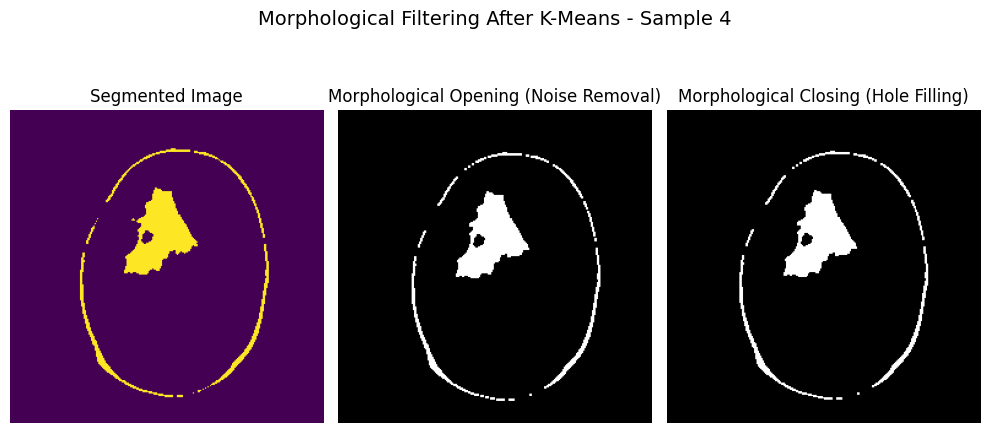

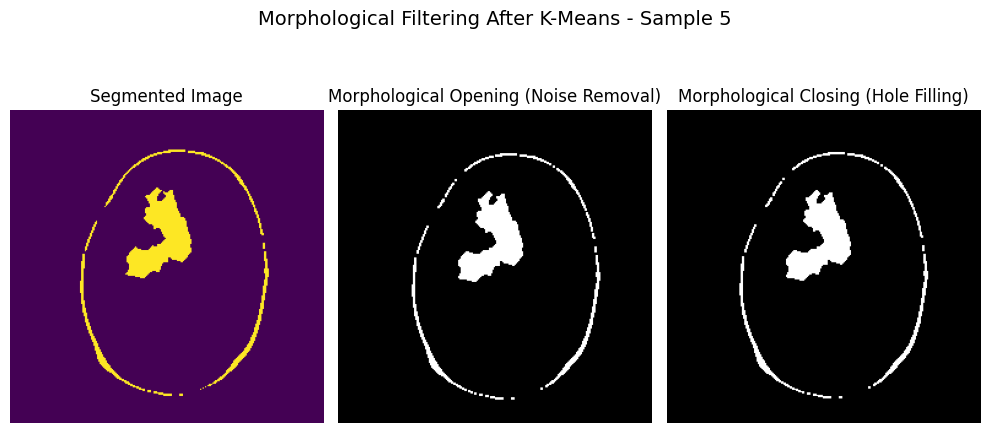

In [ ]:
kernel = np.ones((2, 2), np.uint8)

# Apply morphological filtering to ALL K-Means clustered images
closed_results = []

for img in kmeans_results:
    target_cluster = np.max(img)  # Select the lightest cluster
    binary_mask = np.where(img == target_cluster, 255, 0).astype(np.uint8)

    # Apply Morphological filtering
    opened = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=1)  # Removes noise
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)  # Fills holes

    # Store processed image
    closed_results.append(closed)

# Extract only sample images for display
sample_closed = [closed_results[i] for i in sample_indices]

# Display Sample Morphological Filtering Results
num_samples = len(sample_indices)
for i in range(num_samples):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    fig.suptitle(f"Morphological Filtering After K-Means - Sample {i+1}", fontsize=14)

    axes[0].imshow(np.where(sample_kmeans[i] == np.max(sample_kmeans[i]), 255, 0), cmap="viridis")
    axes[0].set_title("Segmented Image")
    axes[0].axis("off")

    axes[1].imshow(cv2.morphologyEx(sample_closed[i], cv2.MORPH_OPEN, kernel), cmap="gray")
    axes[1].set_title("Morphological Opening (Noise Removal)")
    axes[1].axis("off")

    axes[2].imshow(sample_closed[i], cmap="gray")
    axes[2].set_title("Morphological Closing (Hole Filling)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

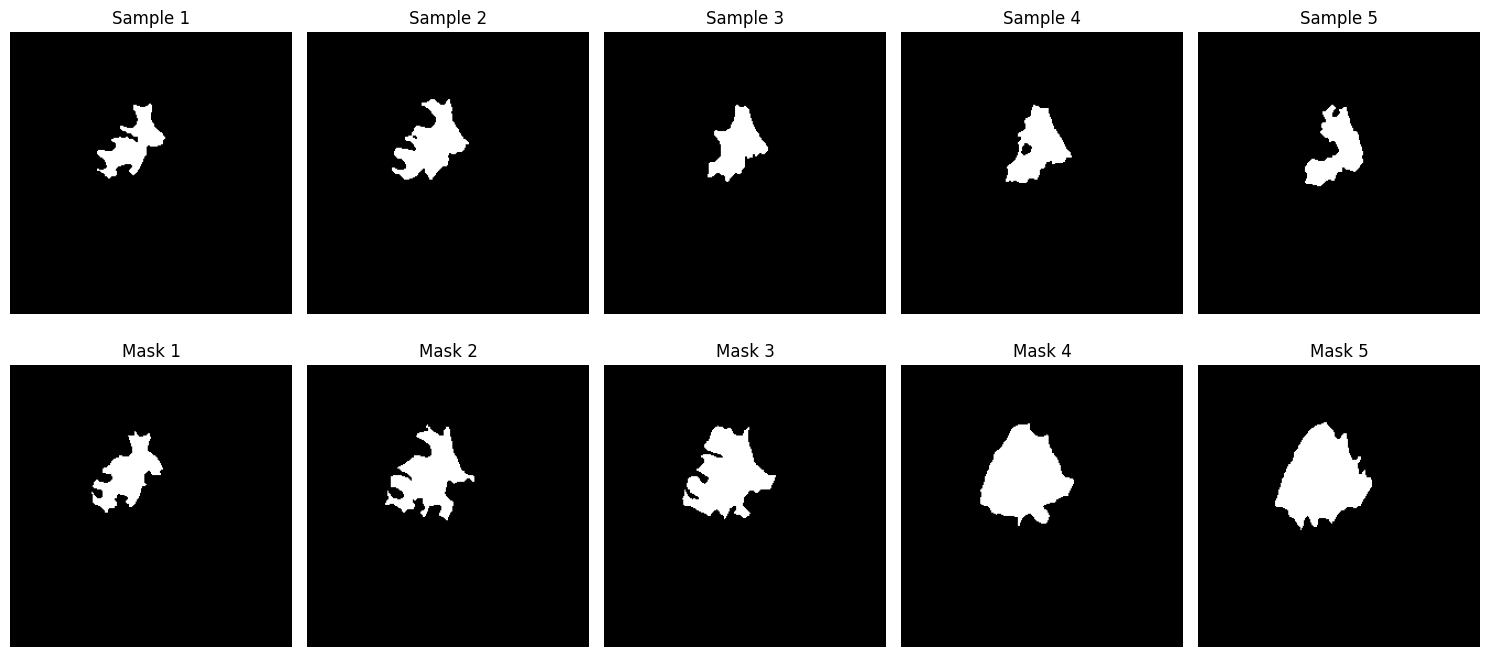

In [ ]:
#CCA with the same function in 1st segmentation method

kmeans_cca_images = [keep_largest_component(img) for img in closed_results]

# Display results
sample_kmeans_cca = [kmeans_cca_images[i] for i in sample_indices]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
fig.suptitle("CCA K-Means Results", fontsize=14)

for i, img in enumerate(sample_kmeans_cca):
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f"Sample {i+1}")
    axes[0, i].axis("off")

    axes[1, i].imshow(sample_masks[i], cmap="gray")
    axes[1, i].set_title(f"Mask {i+1}")
    axes[1, i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 1.2])
plt.show()

## 4. Performance Evaluation


In [ ]:
# Import Libraries for analysis
import warnings
from sklearn.cluster import KMeans
from prettytable import PrettyTable

# Ignore warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load image with masks
image_paths = sorted(
    [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith(".tif")],
    key=lambda x: int(os.path.splitext(os.path.basename(x))[0])
)

mask_paths = sorted(
    [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith(".tif")],
    key=lambda x: int(os.path.splitext(os.path.basename(x))[0])
)

# Read all images and masks into lists
images = [cv2.imread(img_path) for img_path in image_paths]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]
masks = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in mask_paths]

# Evaluation Metrics
eps = 1e-8
num_images = len(image_paths)

# Compare K-Means with Ground Truth
error_kmeans = np.zeros((num_images, 1))
precision_kmeans = np.zeros((num_images, 1))
recall_kmeans = np.zeros((num_images, 1))
iou_kmeans = np.zeros((num_images, 1))

# Compare Thresholding with Ground Truth
error_threshold = np.zeros((num_images, 1))
precision_threshold = np.zeros((num_images, 1))
recall_threshold = np.zeros((num_images, 1))
iou_threshold = np.zeros((num_images, 1))

for i, name in enumerate(image_paths):
    base_number = os.path.splitext(os.path.basename(name))[0]

    kmeans_path = os.path.join(output_k_dir, f"{base_number}.tif")
    thresholding_path = os.path.join(output_t_dir, f"{base_number}.tif")
    gt_path = os.path.join(mask_dir, f"{base_number}.tif")

    kmeans_output = cv2.imread(kmeans_path, cv2.IMREAD_GRAYSCALE)
    thresholding_output = cv2.imread(thresholding_path, cv2.IMREAD_GRAYSCALE)
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    if kmeans_output is None or gt is None:
        print(f"Warning: Missing K-Means file {base_number}, skipping...")
        continue

    kmeans_output = (kmeans_output > 127).astype(np.uint8)
    thresholding_output = (thresholding_output > 127).astype(np.uint8)
    gt = (gt > 127).astype(np.uint8)

    precision_kmeans[i] = np.sum(gt * kmeans_output) / (np.sum(kmeans_output) + eps)
    recall_kmeans[i] = np.sum(gt * kmeans_output) / (np.sum(gt) + eps)
    error_kmeans[i] = 1 - ((2 * precision_kmeans[i] * recall_kmeans[i]) / (precision_kmeans[i] + recall_kmeans[i] + eps))
    iou_kmeans[i] = (np.sum(gt * kmeans_output) / np.sum(np.clip(gt + kmeans_output, 0, 1))) if np.sum(np.clip(gt + kmeans_output, 0, 1)) > 0 else 0

    if thresholding_output is None:
        print(f"Warning: Missing Thresholding file {base_number}, skipping...")
        continue

    precision_threshold[i] = np.sum(gt * thresholding_output) / (np.sum(thresholding_output) + eps)
    recall_threshold[i] = np.sum(gt * thresholding_output) / (np.sum(gt) + eps)
    error_threshold[i] = 1 - ((2 * precision_threshold[i] * recall_threshold[i]) / (precision_threshold[i] + recall_threshold[i] + eps))
    iou_threshold[i] = (np.sum(gt * thresholding_output) / np.sum(np.clip(gt + thresholding_output, 0, 1))) if np.sum(np.clip(gt + thresholding_output, 0, 1)) > 0 else 0

# Print performance scores
t = PrettyTable(["Method", "Error", "Precision", "Recall", "IoU"])

t.add_row(["Thresholding vs GT", round(np.mean(error_threshold), 4), round(np.mean(precision_threshold), 4), round(np.mean(recall_threshold), 4), round(np.mean(iou_threshold), 4)])
t.add_row(["K-Means vs GT", round(np.mean(error_kmeans), 4), round(np.mean(precision_kmeans), 4), round(np.mean(recall_kmeans), 4), round(np.mean(iou_kmeans), 4)])
print(t)

+--------------------+--------+-----------+--------+--------+
|       Method       | Error  | Precision | Recall |  IoU   |
+--------------------+--------+-----------+--------+--------+
| Thresholding vs GT | 0.7445 |   0.2593  | 0.3193 | 0.2029 |
|   K-Means vs GT    | 0.8658 |   0.1537  | 0.1387 | 0.108  |
+--------------------+--------+-----------+--------+--------+


In [ ]:
#Let's see how some sample perform

sample_evaluation = [336, 337, 338, 339, 340]

selected_image_paths = [image_paths[i] for i in sample_evaluation]

# Evaluation Metrics
eps = 1e-8
num_images = len(selected_image_paths)

# Compare K-Means with Ground Truth
error_kmeans = np.zeros((num_images, 1))
precision_kmeans = np.zeros((num_images, 1))
recall_kmeans = np.zeros((num_images, 1))
iou_kmeans = np.zeros((num_images, 1))

# Compare Thresholding with Ground Truth
error_threshold = np.zeros((num_images, 1))
precision_threshold = np.zeros((num_images, 1))
recall_threshold = np.zeros((num_images, 1))
iou_threshold = np.zeros((num_images, 1))

for i, name in enumerate(selected_image_paths):
    base_number = os.path.splitext(os.path.basename(name))[0]

    kmeans_path = os.path.join(output_k_dir, f"{base_number}.tif")
    thresholding_path = os.path.join(output_t_dir, f"{base_number}.tif")
    gt_path = os.path.join(mask_dir, f"{base_number}.tif")

    kmeans_output = cv2.imread(kmeans_path, cv2.IMREAD_GRAYSCALE)
    thresholding_output = cv2.imread(thresholding_path, cv2.IMREAD_GRAYSCALE)
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    if kmeans_output is None or gt is None:
        print(f"Warning: Missing K-Means file {base_number}, skipping...")
        continue

    kmeans_output = (kmeans_output > 127).astype(np.uint8)
    thresholding_output = (thresholding_output > 127).astype(np.uint8)
    gt = (gt > 127).astype(np.uint8)

    precision_kmeans[i] = np.sum(gt * kmeans_output) / (np.sum(kmeans_output) + eps)
    recall_kmeans[i] = np.sum(gt * kmeans_output) / (np.sum(gt) + eps)
    error_kmeans[i] = 1 - ((2 * precision_kmeans[i] * recall_kmeans[i]) / (precision_kmeans[i] + recall_kmeans[i] + eps))
    iou_kmeans[i] = (np.sum(gt * kmeans_output) / np.sum(np.clip(gt + kmeans_output, 0, 1))) if np.sum(np.clip(gt + kmeans_output, 0, 1)) > 0 else 0

    if thresholding_output is None:
        print(f"Warning: Missing Thresholding file {base_number}, skipping...")
        continue

    precision_threshold[i] = np.sum(gt * thresholding_output) / (np.sum(thresholding_output) + eps)
    recall_threshold[i] = np.sum(gt * thresholding_output) / (np.sum(gt) + eps)
    error_threshold[i] = 1 - ((2 * precision_threshold[i] * recall_threshold[i]) / (precision_threshold[i] + recall_threshold[i] + eps))
    iou_threshold[i] = (np.sum(gt * thresholding_output) / np.sum(np.clip(gt + thresholding_output, 0, 1))) if np.sum(np.clip(gt + thresholding_output, 0, 1)) > 0 else 0

# Print performance scores
t = PrettyTable(["Method", "Error", "Precision", "Recall", "IoU"])

t.add_row(["Thresholding vs GT", round(np.mean(error_threshold), 4), round(np.mean(precision_threshold), 4), round(np.mean(recall_threshold), 4), round(np.mean(iou_threshold), 4)])
t.add_row(["K-Means vs GT", round(np.mean(error_kmeans), 4), round(np.mean(precision_kmeans), 4), round(np.mean(recall_kmeans), 4), round(np.mean(iou_kmeans), 4)])
print(t)

+--------------------+--------+-----------+--------+--------+
|       Method       | Error  | Precision | Recall |  IoU   |
+--------------------+--------+-----------+--------+--------+
| Thresholding vs GT | 0.1031 |   0.9171  | 0.8888 | 0.8141 |
|   K-Means vs GT    | 0.3194 |   0.9582  | 0.5464 | 0.525  |
+--------------------+--------+-----------+--------+--------+


In [ ]:
# Let's see how the top 5 best segmented results perform

metrics_threshold = []
metrics_kmeans = []

for i, name in enumerate(image_paths):
    base_number = os.path.splitext(os.path.basename(name))[0]

    kmeans_path = os.path.join(output_k_dir, f"{base_number}.tif")
    thresholding_path = os.path.join(output_t_dir, f"{base_number}.tif")
    gt_path = os.path.join(mask_dir, f"{base_number}.tif")

    kmeans_output = cv2.imread(kmeans_path, cv2.IMREAD_GRAYSCALE)
    thresholding_output = cv2.imread(thresholding_path, cv2.IMREAD_GRAYSCALE)
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    if kmeans_output is None or gt is None:
        print(f"Warning: Missing K-Means file {base_number}, skipping...")
        continue

    kmeans_output = (kmeans_output > 127).astype(np.uint8)
    thresholding_output = (thresholding_output > 127).astype(np.uint8)
    gt = (gt > 127).astype(np.uint8)

    # K-Means Evaluation
    precision_kmeans = np.sum(gt * kmeans_output) / (np.sum(kmeans_output) + eps)
    recall_kmeans = np.sum(gt * kmeans_output) / (np.sum(gt) + eps)
    error_kmeans = 1 - ((2 * precision_kmeans * recall_kmeans) / (precision_kmeans + recall_kmeans + eps))
    iou_kmeans = np.sum(gt * kmeans_output) / np.sum(np.clip(gt + kmeans_output, 0, 1)) if np.sum(np.clip(gt + kmeans_output, 0, 1)) > 0 else 0

    metrics_kmeans.append((base_number, error_kmeans, precision_kmeans, recall_kmeans, iou_kmeans))

    if thresholding_output is None:
        print(f"Warning: Missing Thresholding file {base_number}, skipping...")
        continue

    # Thresholding Evaluation
    precision_threshold = np.sum(gt * thresholding_output) / (np.sum(thresholding_output) + eps)
    recall_threshold = np.sum(gt * thresholding_output) / (np.sum(gt) + eps)
    error_threshold = 1 - ((2 * precision_threshold * recall_threshold) / (precision_threshold + recall_threshold + eps))
    iou_threshold = np.sum(gt * thresholding_output) / np.sum(np.clip(gt + thresholding_output, 0, 1)) if np.sum(np.clip(gt + thresholding_output, 0, 1)) > 0 else 0

    metrics_threshold.append((base_number, error_threshold, precision_threshold, recall_threshold, iou_threshold))

# Sort the results based on error rate (lower is better)
metrics_kmeans.sort(key=lambda x: x[1], reverse=False)
metrics_threshold.sort(key=lambda x: x[1], reverse=False)

def print_top_5_results(metrics, method_name):
    table = PrettyTable(["Image", "Error", "Precision", "Recall", "IoU"])
    sum_error, sum_precision, sum_recall, sum_iou = 0, 0, 0, 0
    count = min(5, len(metrics))

    for i in range(count):
        image, error, precision, recall, iou = metrics[i]
        table.add_row([image, round(error, 4), round(precision, 4), round(recall, 4), round(iou, 4)])
        sum_error += error
        sum_precision += precision
        sum_recall += recall
        sum_iou += iou

    if count > 0:
        table.add_row(["Average", round(sum_error / count, 4), round(sum_precision / count, 4), round(sum_recall / count, 4), round(sum_iou / count, 4)])

    print(f"\nTop 5 Best Results for {method_name}:")
    print(table)

print_top_5_results(metrics_threshold, "Thresholding")
print_top_5_results(metrics_kmeans, "K-Means")


Top 5 Best Results for Thresholding:
+---------+--------+-----------+--------+--------+
|  Image  | Error  | Precision | Recall |  IoU   |
+---------+--------+-----------+--------+--------+
|   1270  | 0.0305 |   0.9907  | 0.9492 | 0.9408 |
|   1272  | 0.0354 |   0.988   | 0.9423 | 0.9317 |
|   1271  | 0.0371 |   0.9783  | 0.948  | 0.9285 |
|   1273  | 0.0438 |   0.994   | 0.9211 | 0.916  |
|    74   | 0.045  |   0.9933  | 0.9196 | 0.9139 |
| Average | 0.0384 |   0.9889  | 0.936  | 0.9262 |
+---------+--------+-----------+--------+--------+

Top 5 Best Results for K-Means:
+---------+--------+-----------+--------+--------+
|  Image  | Error  | Precision | Recall |  IoU   |
+---------+--------+-----------+--------+--------+
|   1270  | 0.0551 |   0.949   | 0.9408 | 0.8955 |
|   1272  | 0.061  |   0.9424  | 0.9356 | 0.885  |
|    25   | 0.0642 |   0.9403  | 0.9312 | 0.8793 |
|   1058  | 0.0645 |   0.9326  | 0.9383 | 0.8787 |
|   1271  | 0.0693 |   0.9273  | 0.9341 | 0.8704 |
| Average |

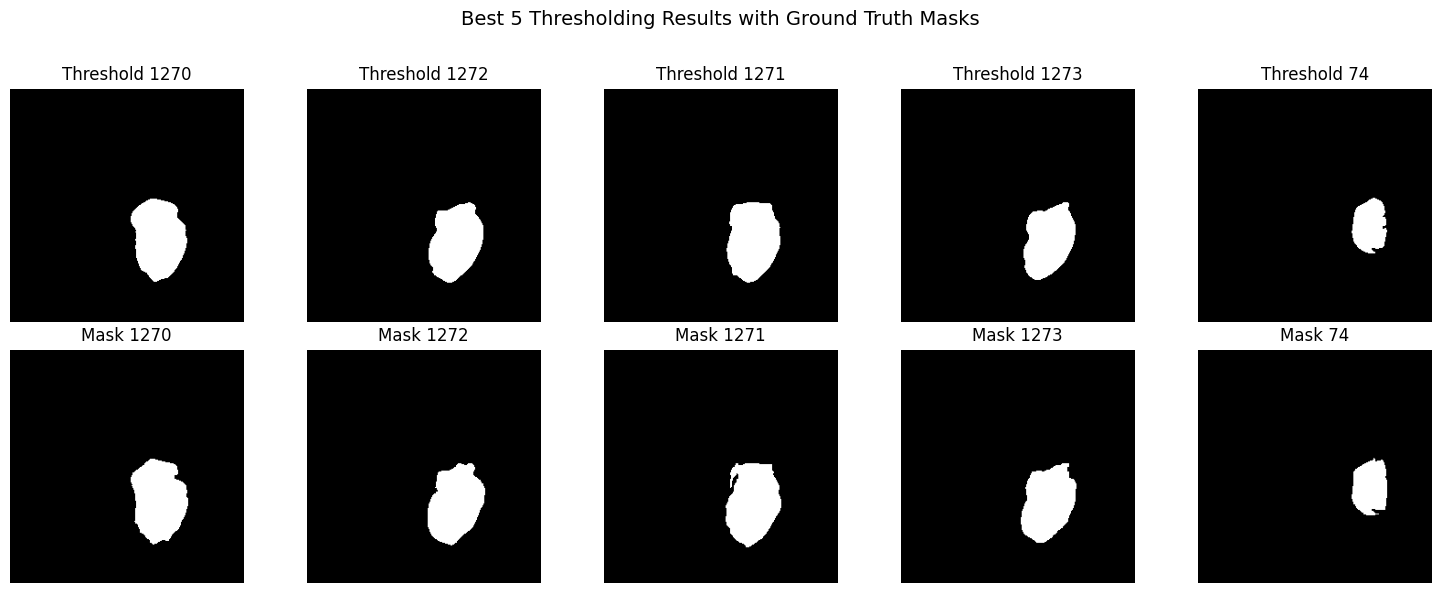

In [ ]:
selected_images = ["1270", "1272", "1271", "1273", "74"]

selected_threshold = []
selected_masks = []

for base_number in selected_images:
    thresholding_path = os.path.join(output_t_dir, f"{base_number}.tif")
    mask_path = os.path.join(mask_dir, f"{base_number}.tif")

    threshold_img = cv2.imread(thresholding_path)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if threshold_img is None or mask_img is None:
        print(f"Warning: Missing file for {base_number}, skipping...")
        continue

    threshold_img = cv2.cvtColor(threshold_img, cv2.COLOR_BGR2RGB)

    selected_threshold.append(threshold_img)
    selected_masks.append(mask_img)

num_samples = min(5, len(selected_threshold))

fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(15, 6))
fig.suptitle("Best 5 Thresholding Results with Ground Truth Masks", fontsize=14)

for i in range(num_samples):
    axes[0, i].imshow(selected_threshold[i])
    axes[0, i].set_title(f"Threshold {selected_images[i]}")
    axes[0, i].axis("off")

    axes[1, i].imshow(selected_masks[i], cmap="gray")
    axes[1, i].set_title(f"Mask {selected_images[i]}")
    axes[1, i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

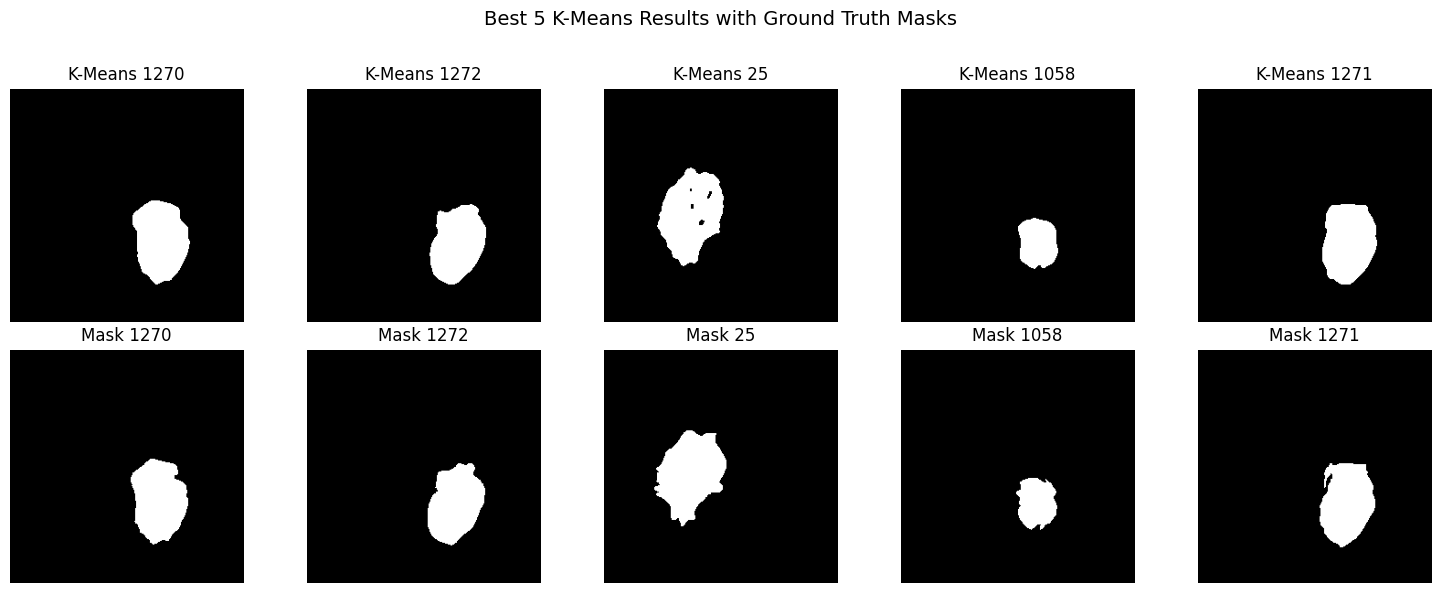

In [ ]:
selected_images = ["1270", "1272", "25", "1058", "1271"]

selected_kmeans = []
selected_masks = []

for base_number in selected_images:
    kmeans_path = os.path.join(output_k_dir, f"{base_number}.tif")
    mask_path = os.path.join(mask_dir, f"{base_number}.tif")

    kmeans_img = cv2.imread(kmeans_path)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if kmeans_img is None or mask_img is None:
        print(f"Warning: Missing file for {base_number}, skipping...")
        continue

    kmeans_img = cv2.cvtColor(kmeans_img, cv2.COLOR_BGR2RGB)

    selected_kmeans.append(kmeans_img)
    selected_masks.append(mask_img)

num_samples = min(5, len(selected_kmeans))

fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(15, 6))
fig.suptitle("Best 5 K-Means Results with Ground Truth Masks", fontsize=14)

for i in range(num_samples):
    axes[0, i].imshow(selected_kmeans[i])
    axes[0, i].set_title(f"K-Means {selected_images[i]}")
    axes[0, i].axis("off")

    axes[1, i].imshow(selected_masks[i], cmap="gray")
    axes[1, i].set_title(f"Mask {selected_images[i]}")
    axes[1, i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# Now let's see top 5 worse results of both methods

# Sort the results based on error rate (higher = bad)
metrics_kmeans.sort(key=lambda x: x[1], reverse= True)
metrics_threshold.sort(key=lambda x: x[1], reverse= True)

def print_worse_5_results(metrics, method_name):
    table = PrettyTable(["Image", "Error", "Precision", "Recall", "IoU"])
    sum_error, sum_precision, sum_recall, sum_iou = 0, 0, 0, 0
    count = min(5, len(metrics))

    for i in range(count):
        image, error, precision, recall, iou = metrics[i]
        table.add_row([image, round(error, 4), round(precision, 4), round(recall, 4), round(iou, 4)])
        sum_error += error
        sum_precision += precision
        sum_recall += recall
        sum_iou += iou

    if count > 0:
        table.add_row(["Average", round(sum_error / count, 4), round(sum_precision / count, 4), round(sum_recall / count, 4), round(sum_iou / count, 4)])

    print(f"\nTop 5 Worse Results for {method_name}:")
    print(table)

print_worse_5_results(metrics_threshold, "Thresholding")
print_worse_5_results(metrics_kmeans, "K-Means")


Top 5 Worse Results for Thresholding:
+---------+-------+-----------+--------+-----+
|  Image  | Error | Precision | Recall | IoU |
+---------+-------+-----------+--------+-----+
|    1    |  1.0  |    0.0    |  0.0   | 0.0 |
|    3    |  1.0  |    0.0    |  0.0   | 0.0 |
|    9    |  1.0  |    0.0    |  0.0   | 0.0 |
|    10   |  1.0  |    0.0    |  0.0   | 0.0 |
|    11   |  1.0  |    0.0    |  0.0   | 0.0 |
| Average |  1.0  |    0.0    |  0.0   | 0.0 |
+---------+-------+-----------+--------+-----+

Top 5 Worse Results for K-Means:
+---------+-------+-----------+--------+-----+
|  Image  | Error | Precision | Recall | IoU |
+---------+-------+-----------+--------+-----+
|    1    |  1.0  |    0.0    |  0.0   | 0.0 |
|    2    |  1.0  |    0.0    |  0.0   | 0.0 |
|    3    |  1.0  |    0.0    |  0.0   | 0.0 |
|    8    |  1.0  |    0.0    |  0.0   | 0.0 |
|    9    |  1.0  |    0.0    |  0.0   | 0.0 |
| Average |  1.0  |    0.0    |  0.0   | 0.0 |
+---------+-------+-----------+---

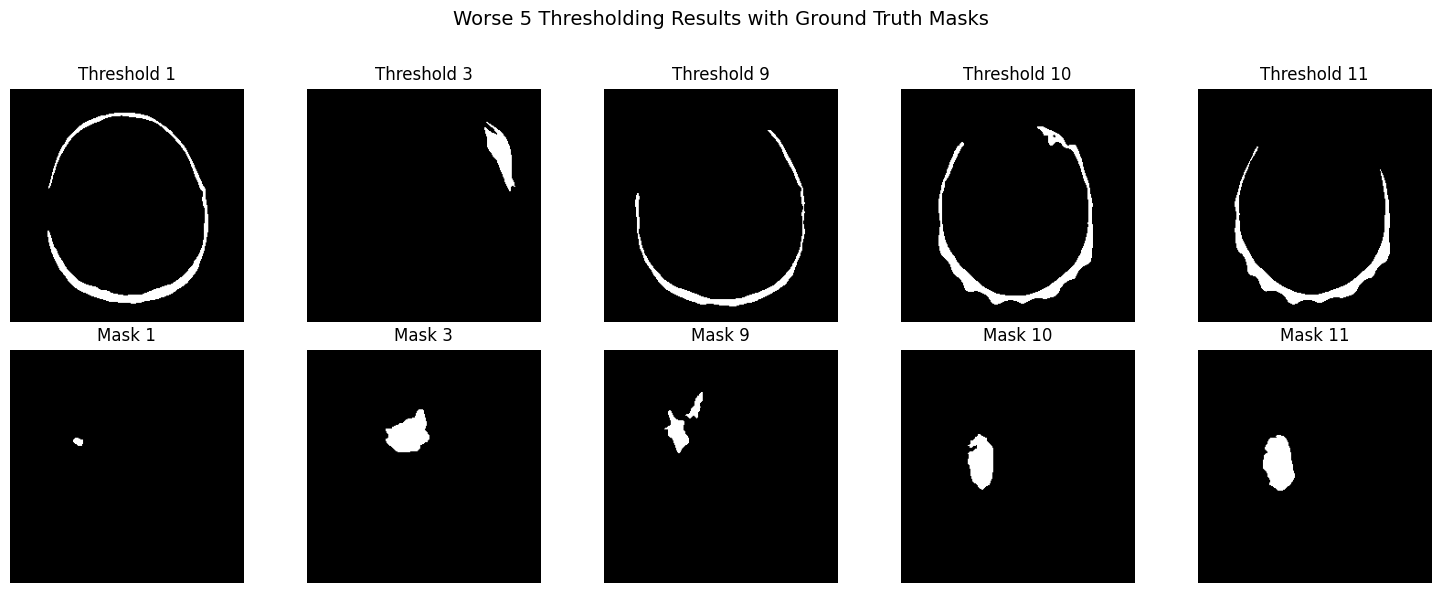

In [ ]:
selected_images = ["1", "3", "9", "10", "11"]

selected_threshold = []
selected_masks = []

for base_number in selected_images:
    thresholding_path = os.path.join(output_t_dir, f"{base_number}.tif")
    mask_path = os.path.join(mask_dir, f"{base_number}.tif")

    threshold_img = cv2.imread(thresholding_path)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if threshold_img is None or mask_img is None:
        print(f"Warning: Missing file for {base_number}, skipping...")
        continue

    threshold_img = cv2.cvtColor(threshold_img, cv2.COLOR_BGR2RGB)

    selected_threshold.append(threshold_img)
    selected_masks.append(mask_img)

num_samples = min(5, len(selected_threshold))

fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(15, 6))
fig.suptitle("Worse 5 Thresholding Results with Ground Truth Masks", fontsize=14)

for i in range(num_samples):
    axes[0, i].imshow(selected_threshold[i])
    axes[0, i].set_title(f"Threshold {selected_images[i]}")
    axes[0, i].axis("off")

    axes[1, i].imshow(selected_masks[i], cmap="gray")
    axes[1, i].set_title(f"Mask {selected_images[i]}")
    axes[1, i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

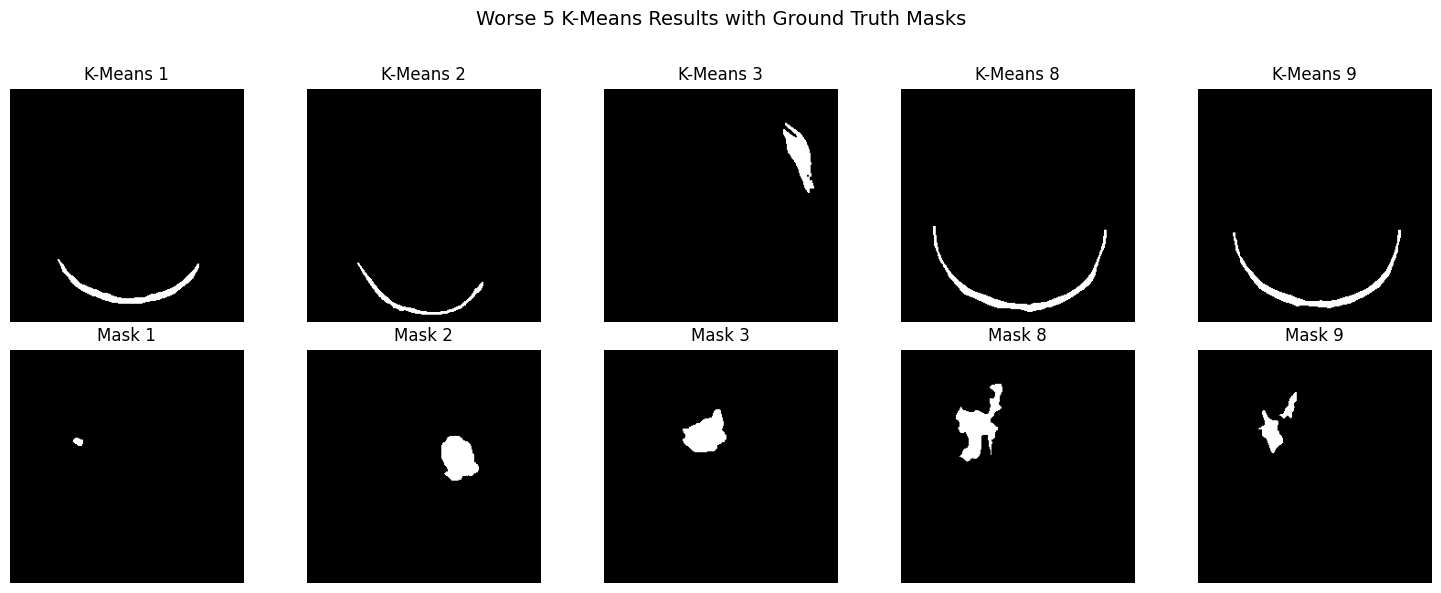

In [ ]:
selected_images = ["1", "2", "3", "8", "9"]

selected_kmeans = []
selected_masks = []

for base_number in selected_images:
    kmeans_path = os.path.join(output_k_dir, f"{base_number}.tif")
    mask_path = os.path.join(mask_dir, f"{base_number}.tif")

    kmeans_img = cv2.imread(kmeans_path)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if kmeans_img is None or mask_img is None:
        print(f"Warning: Missing file for {base_number}, skipping...")
        continue

    kmeans_img = cv2.cvtColor(kmeans_img, cv2.COLOR_BGR2RGB)

    selected_kmeans.append(kmeans_img)
    selected_masks.append(mask_img)

num_samples = min(5, len(selected_kmeans))

fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(15, 6))
fig.suptitle("Worse 5 K-Means Results with Ground Truth Masks", fontsize=14)

for i in range(num_samples):
    axes[0, i].imshow(selected_kmeans[i])
    axes[0, i].set_title(f"K-Means {selected_images[i]}")
    axes[0, i].axis("off")

    axes[1, i].imshow(selected_masks[i], cmap="gray")
    axes[1, i].set_title(f"Mask {selected_images[i]}")
    axes[1, i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()